<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's install and upgrade the necessary packages

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.1 MB/s eta 0:00:00


Let's import all the necessary functions and packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from dl_utils import plot_history

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score


Check the versions of the packages

In [3]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


Check the runtime device

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

Load the training and test set and display its shape

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


Preprocess the feature vectors (normalize data)

In [4]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


Preprocess the labels (one-hot encodings)

In [5]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Validation data
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [6]:
# Split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # for reproducibility

# Build the models


## Baseline model
Here we implement the MLP seen in the lab: we use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.

This model represents the baseline that we want to improve.

In [9]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
model = MLPModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

## Our model

Our model has a structure which is similar to the baseline, i.e. an MLP with 2 hidden layers. However the model is defined as a class that extends the HyperModel class of the Keras Tuner framework, in order to perform the tuning of some hyperparameters. In particular, we set these **hyperparameters** to be the number of neurons in the two hidden layers, the activation function, the learning rate and the optimizer. The batch size is kept equal to the one that will be used to train the baseline mode, as we have seen in class that the size does not really matter provided that other hyperparameters such as optimizer and learning rate in particular are optimized for it. Furthermore, we wanted to adhere to the original code as much as possible to make each novel choice more impactful.

Additionally, the constructor of the class takes as input the label of the **loss function**, that can be either categorical cross entropy (by default) or categorical focal cross entropy (if specified), both with default initialization parameters. The reason for this will be clear in Section "Training for class imbalances".

Finally, we implemented a **data augmentation** method to increase the number of virtual samples of the training and validation sets, by performing some image transformations, in order to both improve the generalization capability and to make the model more resilient to these transformations. We use ImageDataGenerator as augmenting function, with transformations that include rotations, shifts, zooming and flipping.

In [33]:
class MyMLPModel(kt.HyperModel):
  def __init__(self, loss="categorical_crossentropy"):
        self.loss = loss

  # build function to override
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the actual building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('unitsL1', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('unitsL2', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # Choose the optimizer
      hp_optimizer = hp.Choice('optimizer', values=['sgd', 'adam'])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate, hp_optimizer=hp_optimizer
      )
      return model

  # Builds the model given the parameters
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate,
                   hp_optimizer):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))

      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))

      # Check which is the optimizer for the hyperparameter
      if hp_optimizer == 'sgd':
          optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
      elif hp_optimizer == 'adam':
          optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
      else:
          raise

      if self.loss == "CategoricalFocalCrossentropy":
        loss = tf.keras.losses.CategoricalFocalCrossentropy()
      elif self.loss == "categorical_crossentropy":
        loss = "categorical_crossentropy"

      # Compile the model with the given hyperparameters
      model.compile(optimizer=optimizer,
                    loss=loss, metrics=["accuracy"])
      return model

  # fit function to override
  def fit(self, hp, model, *args, **kwargs):
        # Initialize ImageDataGenerator for data augmentation specifying a bunch of different transformations
        datagen_train = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest'
        )
        # Retrieve the training data
        X_train = args[0]
        # Increase the dimensionality of the data for datagen
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        # Fit the data generator on the training data
        datagen_train.fit(X_train)

        # Initialize ImageDataGenerator for data augmentation specifying a bunch of different transformations
        datagen_val = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest'
        )
        X_val_reshaped = X_val
        # Increase the dimensionality of the data for datagen
        X_val_reshaped = X_val_reshaped.reshape(X_val_reshaped.shape[0], X_val_reshaped.shape[1], X_val_reshaped.shape[2], 1)
        # Fit the data generator on the training data
        datagen_val.fit(X_val_reshaped)

        # Use the generator to augment the data during training
        return model.fit(
        datagen_train.flow(X_train, y_train, batch_size=128, shuffle=True), # Use augmentation on the training set
        validation_data=datagen_val.flow(X_val_reshaped, y_val, batch_size=128, shuffle=True)  # Validation data
        )

Here we define the Keras Tuner to perform the search of the hyperparameters for our previously defined model.

The tuner we use is the Hyperband tuner, which carries out the search using the **Hyperband** algorithm.

From the author of the algorithm: "we focus on speeding up random search through adaptive resource allocation and early-stopping. We formulate hyperparameter optimization as a pure-exploration non-stochastic infinite-armed bandit problem where a predefined resource like iterations, data samples, or features is allocated to randomly sampled configurations." (more can be read at https://doi.org/10.48550/arXiv.1603.06560).

In [34]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=20,
                     #overwrite = True,
                     max_consecutive_failed_trials=5,
                     project_name='my_mlp_tuning',
                     directory='my_mlp_tuning',
)
# Summarize the search space
tuner.search_space_summary()

Search space summary
Default search space size: 5
unitsL1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unitsL2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam'], 'ordered': False}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8297 - loss: 0.5118 - val_accuracy: 0.8314 - val_loss: 0.5005
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8383 - loss: 0.4854 - val_accuracy: 0.8330 - val_loss: 0.4879
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8381 - loss: 0.4777 - val_accuracy: 0.8419 - val_loss: 0.4684
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8419 - loss: 0.4639 - val_accuracy: 0.8388 - val_loss: 0.4708
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8463 - loss: 0.4466 - val_accuracy: 0.8460 - val_loss: 0.4558


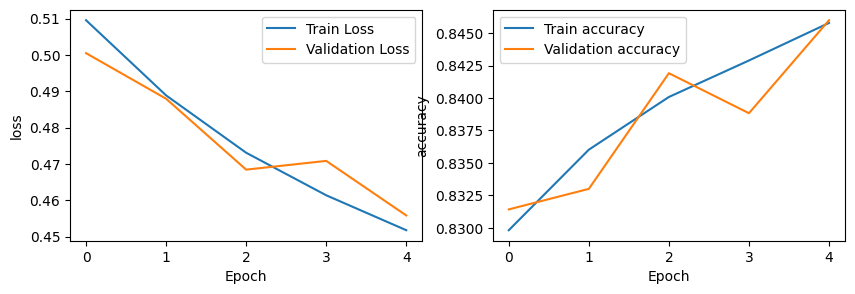

In [35]:
batch_size = 128
epochs = 5

# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
plot_history(history)

Save the baseline model in the workspace

In [36]:
model.save('/content/baseline_model.keras')

## Training the best model

Here we first perform the search of the best parameters using the hyperband tuner previously defined, then we train the best model with a train-validation split. We specify a high number of epochs because the early stopping function allows to stop the training by monitoring the validation loss, to prevent overfitting.

Trial 28 Complete [00h 00m 22s]
val_accuracy: 0.6744166612625122

Best val_accuracy So Far: 0.6949166655540466
Total elapsed time: 00h 07m 36s
Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7825 - loss: 0.6007 - val_accuracy: 0.8563 - val_loss: 0.3863
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8674 - loss: 0.3670 - val_accuracy: 0.8559 - val_loss: 0.3822
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8787 - loss: 0.3208 - val_accuracy: 0.8678 - val_loss: 0.3512
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8872 - loss: 0.3042 - val_accuracy: 0.8713 - val_loss: 0.3507
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8936 - loss: 0.2812 - val_accuracy: 0.8802 - val_loss: 0.3321
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.2642 - val_accuracy: 0.8745 - val_loss: 0.3468
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9044 - lo

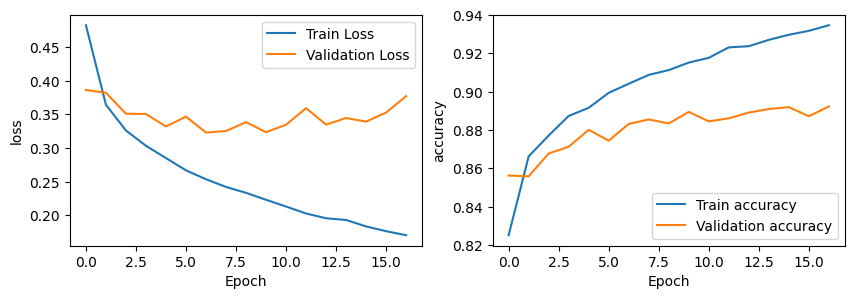

Best epoch: 17


In [37]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=10,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=5,
)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for maximum 50 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

# Plot the training summary
plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Save the best model in the workspace

In [38]:
best_model.save('/content/best_model.keras')

# Evaluation

## Baseline evaluation

Print the loss and accuracy of the trained baseline model.

In [39]:
base_score = model.evaluate(X_test, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 0.49183547496795654
Test accuracy: 0.8317999839782715


## Best model evaluation
Print the best hyperparameters found by the hyperband tuner.

Print the loss and accuracy of the best model.

Print the accuracy increment in the test set.

The test set is not subject to augmentation as it should not be manipulated, but only be used as references for evaluation.

In [40]:
best_score = best_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

Best model
Best parameters: {'unitsL1': 416, 'unitsL2': 480, 'activation': 'relu', 'learning_rate': 0.001, 'optimizer': 'adam', 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Test loss: 0.3443635106086731
Test accuracy: 0.8791999816894531
Test accuracy improvement: 5.6984850473884885 %


## Transformations test

Here we create an augmented test set by apply the same data augmentation as defined for our model to the test set, and then sample a few images just to check the strengths and weaknesses of the model in these scenarios.

Notice that the actual test set is left intact for proper evaluation.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of X_augmented: (10000, 28, 28)
Shape of y_augmented: (10000, 10)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


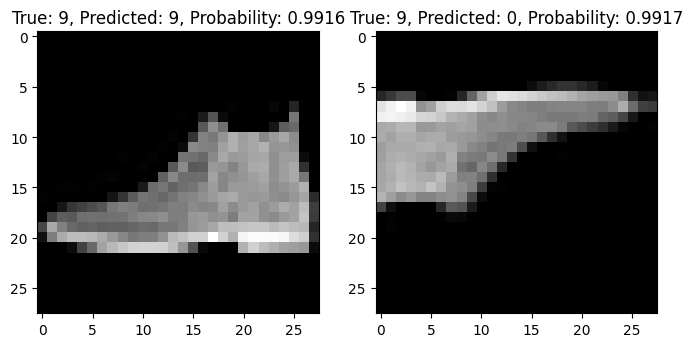

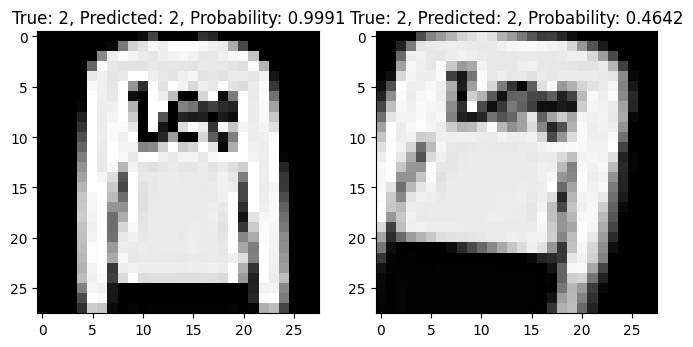

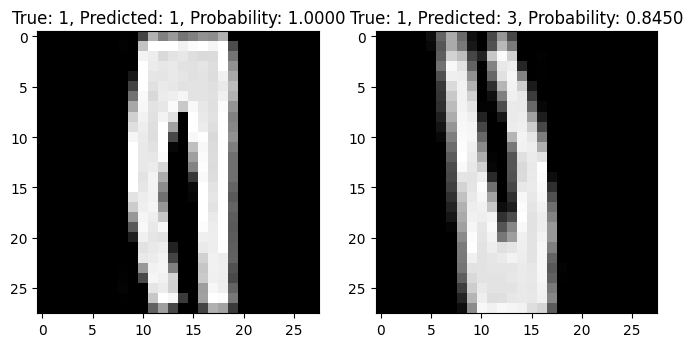

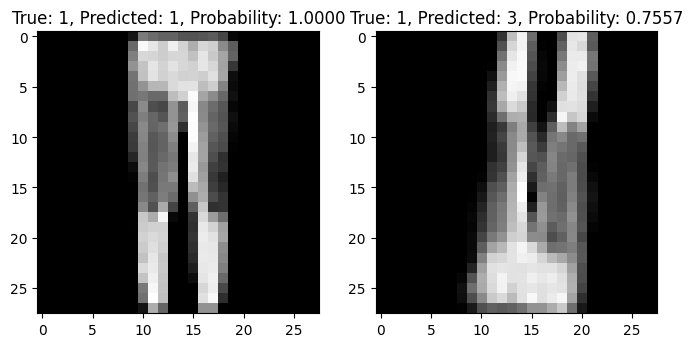

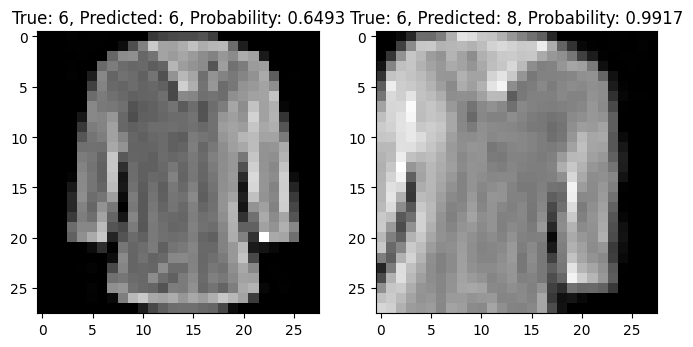

In [49]:
# Create the same ImageDataGenerator for augmentation as in the definition of our model
datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip = True,
  fill_mode='nearest',
  validation_split=0.2
)

# Lists to store augmented data
X_augmented = []
y_augmented = []

# The predicted probabilities for each class
y_pred_probs = best_model.predict(X_test)
# The corresponding predicted labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Iterate through all training examples
for i in range(len(X_test)):
    # Reshape the image to (1, height, width, channels) for flow method
    img = X_test[i].reshape((1,) + X_test[i].shape + (1,))

    # Generate augmented images and store in X_augmented and y_augmented
    for batch, labels_batch in datagen.flow(img, y_test[i].reshape(1, -1), batch_size=1):
        X_augmented.append(batch[0].reshape(X_test[i].shape))
        y_augmented.append(labels_batch[0])
        break  # Exit the loop after one augmented image

# Convert lists to NumPy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Check the shape of augmented data
print("Shape of X_augmented:", X_augmented.shape)
print("Shape of y_augmented:", y_augmented.shape)

# The predicted probabilities for each class
y_pred_probs_aug = best_model.predict(X_augmented)
# The corresponding predicted labels
y_pred_labels_aug = np.argmax(y_pred_probs_aug, axis=1)

# Display the first 10 examples
for i in range(10):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].reshape(X_test[i].shape), cmap="gray")
    plt.title(f'True: {np.argmax(y_test[i])}, Predicted: {y_pred_labels[i]}, Probability: {y_pred_probs[i, y_pred_labels[i]]:.4f}')

    plt.subplot(1, 2, 2)
    plt.imshow(X_augmented[i].reshape(X_augmented[i].shape), cmap="gray")
    plt.title(f'True: {np.argmax(y_augmented[i])}, Predicted: {y_pred_labels_aug[i]}, Probability: {y_pred_probs_aug[i, y_pred_labels_aug[i]]:.4f}')

    plt.show()

Overall we can state that despite performing data augmentation on the training and validation data, the model is mostly struggling to predict the correct labels on these kind of images. In fact, correct classification is achieved only with minor transformations like small zooming, few degrees rotation, or horizontal flip. With more disruptive transformations like vertical flip, the model is not able to predict the correct labels.

## Best and worst predictions

Here we plot the 5 best (most confident) and 5 worst (most confused (least confident)) predictions on the test set.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


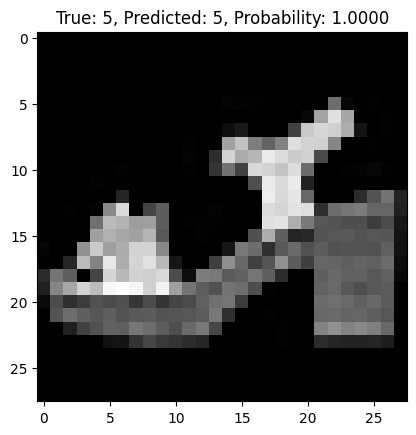

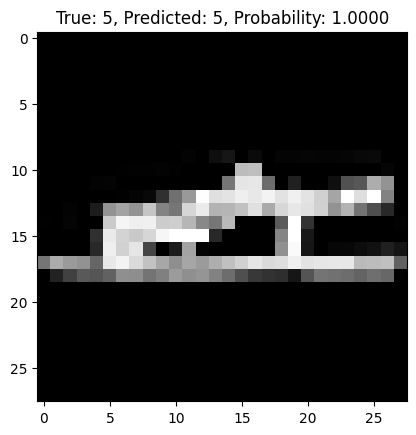

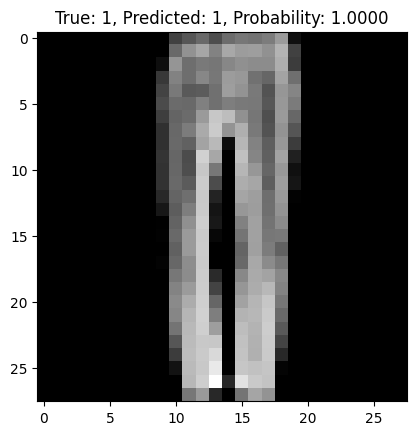

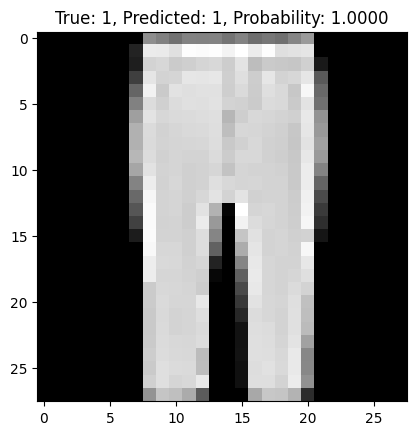

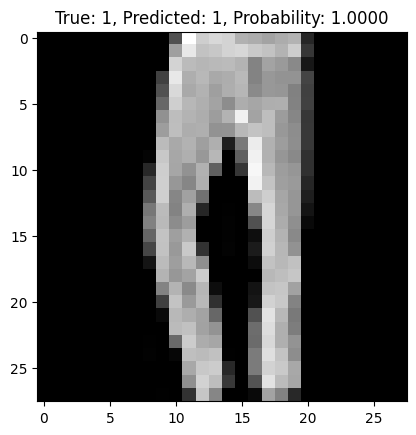

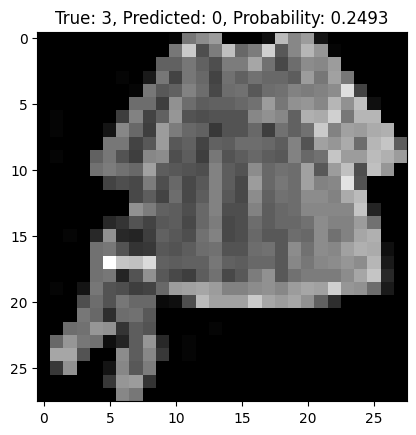

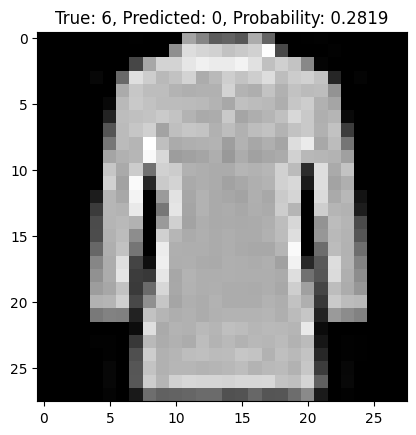

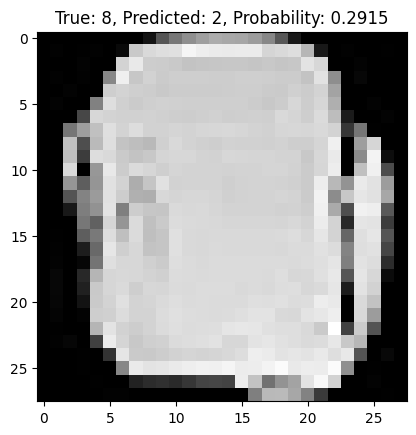

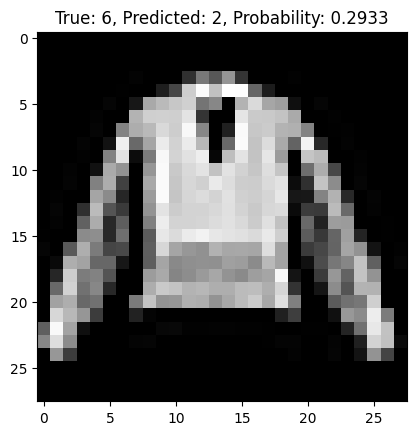

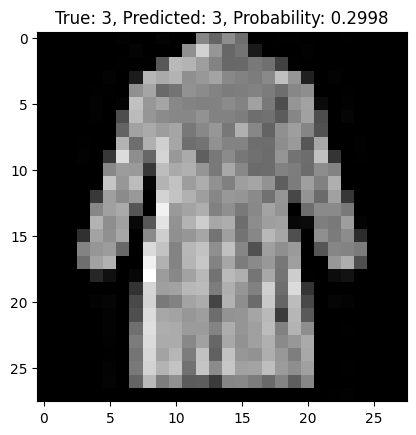

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.99      0.96      0.97      1000
           2       0.82      0.77      0.79      1000
           3       0.85      0.91      0.88      1000
           4       0.75      0.85      0.80      1000
           5       0.97      0.96      0.96      1000
           6       0.75      0.61      0.67      1000
           7       0.96      0.91      0.94      1000
           8       0.98      0.97      0.97      1000
           9       0.92      0.98      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [42]:
# The predicted probabilities for each class
y_pred_probs = best_model.predict(X_test)

# The corresponding predicted labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# The corresponding true labels
y_true_labels = np.argmax(y_test, axis=1)

# A list with the maximum probabilities for each sample
y_max_probs = list(range(len(y_pred_probs)))
for i, row in enumerate(y_pred_probs):
  y_max_probs[i] = np.max(row)

# Retrieve the indices of the sorted list
indices = np.argsort(y_max_probs)

# The last five are the indices of the samples with highest predicted probabilities (most convinced)
most_convinced_indices = indices[-5:]
# The first five are the indices of the samples with lowest predicted probabilities (most confused)
most_confused_indices = indices[:5]

# Print the sample, predicted label and probability in the most convinced case
for index in most_convinced_indices:
    plt.imshow(X_test[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

# Print the sample, predicted label and probability in the most confused case
for index in most_confused_indices:
    plt.imshow(X_test[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

# Print a classification report
print(classification_report(y_true_labels, y_pred_labels))


The model exhibits more weakness in accurately predicting the upper body clothing items probably due to their high similarity in the pixel distributions, while demonstrating strength in classifying items with very distinguishable distributions like bags, trousers and shoes.

# Training for class imbalances

From the classification report, we can see that in the f1 score some classes perform much better than others. This indicates some form of class imbalance, where some classes are clearly harder to learn than others.

Therefore, in order to overcome this problem, we now want to try to improve the classification accuracy for the classes that the model struggled with most.

First of all we try to check whether the training or validation datasets were **unbalanced**, i.e. the number of samples for each class are not similar.

In [43]:
# Count the number of occurrences of 1 in each column
count = np.sum(y_train, axis=0)

# Print the count of ones for each class (column)
print("Training data:")
for class_label, sum in enumerate(count):
    print(f"Class {class_label}: samples {sum}")

# Count the number of occurrences of 1 in each column
count = np.sum(y_val, axis=0)

# Print the count of ones for each class (column)
print("Validation data:")
for class_label, sum in enumerate(count):
    print(f"Class {class_label}: samples {sum}")

Training data:
Class 0: samples 4798.0
Class 1: samples 4781.0
Class 2: samples 4795.0
Class 3: samples 4816.0
Class 4: samples 4798.0
Class 5: samples 4789.0
Class 6: samples 4782.0
Class 7: samples 4841.0
Class 8: samples 4803.0
Class 9: samples 4797.0
Validation data:
Class 0: samples 1202.0
Class 1: samples 1219.0
Class 2: samples 1205.0
Class 3: samples 1184.0
Class 4: samples 1202.0
Class 5: samples 1211.0
Class 6: samples 1218.0
Class 7: samples 1159.0
Class 8: samples 1197.0
Class 9: samples 1203.0


Having seen that the datasets are both balanced, we are going to train a new model using focal loss, since according to Lin et al., 2018 (https://arxiv.org/pdf/1708.02002.pdf) it helps to apply a focal factor to down-weight easy examples and focus more on hard examples.

We are going to follow the same rationale and pipeline of the model we have previously trained, with the only exception that we are going to adopt this different loss function.

## Hyperband tuner
Let's build the hyperband tuner first.

In [44]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner_focal = kt.Hyperband(MyMLPModel(loss="CategoricalFocalCrossentropy"),
                     objective='val_accuracy',
                     max_epochs=20,
                     #overwrite = True,
                     max_consecutive_failed_trials=5,
                     project_name='my_mlp_tuning_focal',
                     directory='my_mlp_tuning_focal',
)
# Summarize the search space
tuner.search_space_summary()

Reloading Tuner from my_mlp_tuning_focal/my_mlp_tuning_focal/tuner0.json
Search space summary
Default search space size: 5
unitsL1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unitsL2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam'], 'ordered': False}


## Training
Let's now run the training routine and plot the results.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7309 - loss: 0.1254 - val_accuracy: 0.7837 - val_loss: 0.0680
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8179 - loss: 0.0592 - val_accuracy: 0.8173 - val_loss: 0.0579
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8351 - loss: 0.0536 - val_accuracy: 0.8367 - val_loss: 0.0523
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8356 - loss: 0.0513 - val_accuracy: 0.8230 - val_loss: 0.0562
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8416 - loss: 0.0502 - val_accuracy: 0.8239 - val_loss: 0.0553
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8487 - loss: 0.0473 - val_accuracy: 0.8359 - val_loss: 0.0517
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8418 - loss: 0.0502 - val_accuracy: 0.8331 - val_loss: 0.0559
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8493 - loss: 0.0466 - 

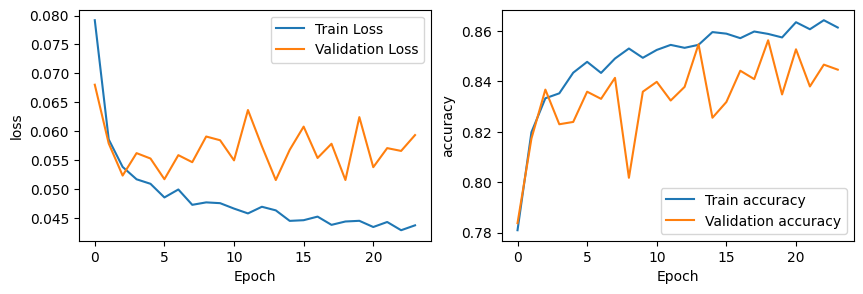

Best epoch: 19


In [45]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=10,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=5,
)

# Perform the search
tuner_focal.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_focal=tuner_focal.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for maximum 50 epochs
best_model_focal = tuner_focal.hypermodel.build(best_hps_focal)
history = best_model_focal.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

# Plot the training summary
plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Save the focal model in the workspace.

In [46]:
best_model_focal.save('/content/best_model_focal.keras')

## Evaluation
Here we display the evaluation statistics of the focal model, and compare the test accuracy with respect to the previous model.

In [47]:
best_score_focal = best_model_focal.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps_focal.values)
print("Test loss:", best_score_focal[0])
print("Test accuracy:", best_score_focal[1])
print("Test accuracy improvement:", 100*(best_score_focal[1]-best_score[1])/best_score[1], "%")

Best model
Best parameters: {'unitsL1': 416, 'unitsL2': 96, 'activation': 'relu', 'learning_rate': 0.01, 'optimizer': 'adam', 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Test loss: 0.0560007318854332
Test accuracy: 0.8450000286102295
Test accuracy improvement: -3.8898946532625813 %


The accuracy has significantly decreased, indicating that this loss may not be ideal for the kind of problem we are trying to solve. It might also be that we need to set different initialization parameters to the loss function.

Here we define a function to compute **class-wise accuracies** given a model and the testing data.

In [ ]:
def compute_class_accuracies(X_data, y_data, model):
  # The predicted probabilities for each class
  y_pred_probs = model.predict(X_data)

  # The corresponding predicted labels
  y_pred_labels = np.argmax(y_pred_probs, axis=1)

  # The corresponding true labels
  y_true_labels = np.argmax(y_data, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_true_labels, y_pred_labels)

  # Compute accuracies and weights for each class
  class_accuracies = []
  for class_label in range(len(cm)):
      class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
      class_accuracies.append(class_accuracy)

  # Print the classification report
  print(classification_report(y_true_labels, y_pred_labels))

  return class_accuracies

Here we compute the class accuracies for the two models on the test data and compare the results.

In [48]:
# Compute class-wise accuracies of the best_model
class_accuracies = compute_class_accuracies(X_test, y_test, best_model)

# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

# Compute class-wise accuracies of the best_model_focal
class_accuracies_focal = compute_class_accuracies(X_test, y_test, best_model_focal)

# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies_focal):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

# Convert lists to numpy arrays
class_accuracies_focal = np.array(class_accuracies_focal)
class_accuracies = np.array(class_accuracies)

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels))

# Compute the difference between the accuracies
class_accuracies_diff = class_accuracies_focal - class_accuracies

# Print the accuracy difference for each class
for class_label, diff in enumerate(class_accuracies_diff):
    print(f"Class {class_label}: Accuracy Increment {diff:.2f}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Class 0: Accuracy 0.88
Class 1: Accuracy 0.97
Class 2: Accuracy 0.78
Class 3: Accuracy 0.92
Class 4: Accuracy 0.86
Class 5: Accuracy 0.98
Class 6: Accuracy 0.64
Class 7: Accuracy 0.89
Class 8: Accuracy 0.95
Class 9: Accuracy 0.97
Class weights based on accuracy: {0: 1.470579274825477, 1: 1.0940996597437573, 2: 2.1405545905211993, 3: 1.2923093154737277, 4: 1.5709117449666345, 5: 1.072699789861169, 6: 3.8223415544519663, 7: 1.4206081832290616, 8: 1.1485337458863896, 9: 1.0954292012303848}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1202
           1       0.99      0.97      0.98      1219
           2       0.85      0.78      0.81      1205
           3       0.86      0.92      0.89      1184
           4       0.76      0.86      0.81      1202
           5       0.95      0.98      0.97      1211
           6       0.77      0.64      0.70      1218
           7       0.97      0.89 